# Evaluating Multiple Models
Lixun Zhang  
Nov 10, 2015

## 1 Introduction
The purpose of this example is to compare the performance of models. 

In this example, the Boston housing dataset that comes with the R package MASS will be used. The dataset has information on median value of owner-occupied homes in $1000's, as well as characteristics such as average number of rooms per dwelling, % lower status of the population, and per capita crime rate by town, etc. More information about the dataset can be found at [UCI Machine Learning Repository][uci link]. 

The dataset is split into two for this analysis: one for training (70% of samples) and one for testing (30% of samples). After a model is developed based on the training data, its performance will be checked on the testing data. Three models will be compared after they are fitted following the steps described in separate examples: [a linear model using all variables][tutorial link], [a linear model after variable selection][varsel link], and [a Gradient Boosting Machine (GBM) model][gbm link]. 

[uci link]: http://archive.ics.uci.edu/ml/datasets/Housing
[tutorial link]: link
[varsel link]: link
[gbm link]: link

## 2 Prepare Data
Following the same step as in [Tutorial for Using Azure Machine Learning Notebook][tutorial link], we first create an Azure ML experiment and then use the following code to bring the Boston housing data from the experiment into the current Python session.

[tutorial link]: link

In [1]:
from azureml import Workspace
ws = Workspace(
 workspace_id='b2bbeb56a1d04e1599d2510a06c59d87',
 authorization_token=<token>,
 endpoint='https://studioapi.azureml.net'
)
experiment = ws.experiments['b2bbeb56a1d04e1599d2510a06c59d87.\
f-id.911630d13cbe4407b9fe408b5bb6ddef']
ds = experiment.get_intermediate_dataset(
 node_id='a0a931cf-9fb3-4cb9-83db-f48211be560c-323',
 port_name='Results dataset',
 data_type_id='GenericCSV'
)
frame = ds.to_dataframe()

mydata = frame

# create X and y
feature_cols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 
                'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']
X = mydata[feature_cols]
y = mydata.medv

Next we split the dataset into two: one with 70% of samples and the other 30%.

In [2]:
from sklearn.cross_validation import train_test_split
# Split the dataset: 70% vs 30%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

## 3 Fit Models
### 3.1 Linear Model
The code in this section is based on that of the [Tutorial for Using Azure Machine Learning Notebook][tutorial link]. 
The following lines of code fit a linear model using all features.

[tutorial link]: link

In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# initiate the linear model and fit with data
lm = LinearRegression()
lm.fit(X_train, y_train)

# print the R-squared
print("The R-squared value is: {0:0.4f} \n".format(lm.score(X_train, y_train)))
# print intercept and coefficients
param_df = pd.DataFrame({"Features": ['intercept'] + feature_cols, "Coef": [lm.intercept_] + list(lm.coef_)})
cols = param_df.columns.tolist()
cols = cols[-1:]+cols[:-1]
param_df = param_df[cols]
print(param_df)

The R-squared value is: 0.7645 

     Features       Coef
0   intercept  37.937108
1        crim  -0.121310
2          zn   0.044466
3       indus   0.011342
4        chas   2.511246
5         nox -16.231253
6          rm   3.859068
7         age  -0.009985
8         dis  -1.500270
9         rad   0.242143
10        tax  -0.011072
11    ptratio  -1.017753
12      black   0.006814
13      lstat  -0.486738


Then we check model performance on the test dataset.

In [6]:
#%% check performance on test data
predicted = lm.predict(X_test)

import numpy as np

mae = np.mean(abs(predicted-y_test))
rmse = np.sqrt(np.mean((predicted-y_test)**2))
rae = np.mean(abs(predicted-y_test))/np.mean(abs(y_test-np.mean(y_test)))
rse = np.mean((predicted-y_test)**2)/np.mean((y_test-np.mean(y_test))**2)

# print metrics on test data
print("The R-squared value is: {0:0.4f}".format(lm.score(X_test, y_test)))
print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

The R-squared value is: 0.6734
Mean Absolute Error: 3.609904
Root Mean Squared Error: 5.214975
Relative Absolute Error: 0.556116
Relative Squared Error: 0.326617


### 3.2 Linear Model with Feature Selection
The code in this section is based on that in the [Variable Selection in Azure ML Jupyter Notebook][varsel link].

The following lines of code select variables using recursive feature elimination.

[varsel link]: link

Optimal number of features : 11
Features selected: ['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']


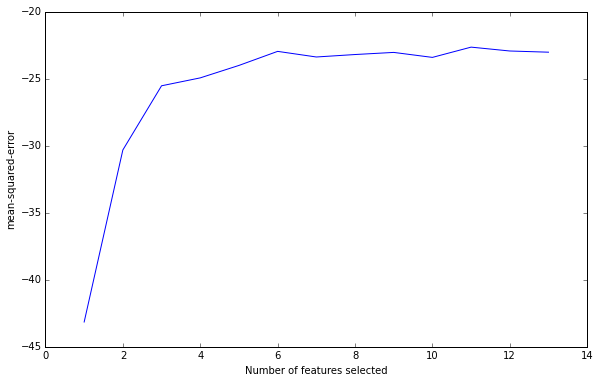

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

#%%
# initiate the linear model
lm = LinearRegression()

# scale the features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_minmax = min_max_scaler.fit_transform(X_train)
x_scaled_minmax_df = pd.DataFrame(x_scaled_minmax, columns = feature_cols)

# recursive feature elimination with cross validation, using r-squared as metric
rfecv = RFECV(estimator=lm, step=1, cv=5, scoring='mean_squared_error')
rfecv.fit(x_scaled_minmax_df, y_train)

# print the optimal number of feature
print("Optimal number of features : %d" % rfecv.n_features_)

# save the selected features
feature_cols_selected = list(np.array(feature_cols)[rfecv.support_])
print("Features selected: " + str(feature_cols_selected))

# plot number of features VS. cross-validation scores
plt.figure(figsize=(6 * 1.618, 6))
plt.xlabel("Number of features selected")
plt.ylabel("mean-squared-error")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Using the selected features we can fit a linear model.

In [10]:
#%% fit model with selected features
X_new = X_train[feature_cols_selected]
lm2 = LinearRegression()
lm2.fit(X_new, y_train)

predicted = lm2.predict(X_train[feature_cols_selected])

rmse = np.sqrt(np.mean((predicted-y_train)**2))
print("Root Mean Squared Error: {0:0.4f}" .format(rmse))
# print the R-squared
print("The R-squared value is: {0:0.4f} \n".format(lm2.score(X_new, y_train)))
# print intercept and coefficients
param_df = pd.DataFrame({"Features": ['intercept'] + feature_cols_selected, "Coef": [lm2.intercept_] + list(lm2.coef_)})
cols = param_df.columns.tolist()
cols = cols[-1:]+cols[:-1]
param_df = param_df[cols]
print(param_df)

Root Mean Squared Error: 4.4703
The R-squared value is: 0.7642 

     Features       Coef
0   intercept  38.188982
1        crim  -0.120769
2          zn   0.045531
3        chas   2.497513
4         nox -16.856417
5          rm   3.787462
6         dis  -1.463373
7         rad   0.241989
8         tax  -0.010830
9     ptratio  -1.020736
10      black   0.006663
11      lstat  -0.499107


Then the model's performance on the test dataset is evaluated.

In [11]:
#%% check performance on test data
X_test_part = X_test[feature_cols_selected]
predicted = lm2.predict(X_test_part)

mae = np.mean(abs(predicted-y_test))
rmse = np.sqrt(np.mean((predicted-y_test)**2))
rae = np.mean(abs(predicted-y_test))/np.mean(abs(y_test-np.mean(y_test)))
rse = np.mean((predicted-y_test)**2)/np.mean((y_test-np.mean(y_test))**2)

# print metrics on test data
print("The R-squared value is: {0:0.4f} \n".format(lm2.score(X_test_part, y_test)))
print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

The R-squared value is: 0.6752 

Mean Absolute Error: 3.595099
Root Mean Squared Error: 5.200632
Relative Absolute Error: 0.553835
Relative Squared Error: 0.324823


### 3.3 GBM
The code in this section is based on that in the [GBM in Azure ML Jupyter Notebook][gbm link].

Before fitting the GBM model, we need to estimate some parameters and we'll do this using cross-validation along with grid search.

[gbm link]: link

In [12]:
#%% use cross validation to estimate hyperparameters on a grid
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from time import time

tuned_params = {'n_estimators': [500, 1000, 10000], 
                'max_depth': [2,4,8], 
                'min_samples_split': [1, 2, 4],
                'learning_rate': [0.001, 0.01, 0.1]}
          
print("# Tuning hyper-parameters for mean_squared_error")

gscv = GridSearchCV(GradientBoostingRegressor(loss = 'ls', random_state=0), 
                    tuned_params, cv=5, scoring='mean_squared_error')

start = time()
gscv.fit(X_train, y_train)
print("The grid cross validation lasted {0:0.2f} seconds"
      .format(time() - start))
print("Best parameters set found on development set:")
print(gscv.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in gscv.grid_scores_:
    print("{0:0.3f} (+/-{1:0.3f}) for {2:s}"
          .format(mean_score, scores.std() * 2, params))

# Tuning hyper-parameters for mean_squared_error
The grid cross validation lasted 626.82 seconds
Best parameters set found on development set:
{'min_samples_split': 1, 'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 2}
Grid scores on development set:
-47.633 (+/-29.494) for {'min_samples_split': 1, 'n_estimators': 500, 'learning_rate': 0.001, 'max_depth': 2}
-30.599 (+/-21.113) for {'min_samples_split': 1, 'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 2}
-11.266 (+/-8.071) for {'min_samples_split': 1, 'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 2}
-47.633 (+/-29.494) for {'min_samples_split': 2, 'n_estimators': 500, 'learning_rate': 0.001, 'max_depth': 2}
-30.599 (+/-21.113) for {'min_samples_split': 2, 'n_estimators': 1000, 'learning_rate': 0.001, 'max_depth': 2}
-11.266 (+/-8.071) for {'min_samples_split': 2, 'n_estimators': 10000, 'learning_rate': 0.001, 'max_depth': 2}
-47.633 (+/-29.494) for {'min_samples_split': 4, 'n_estimators': 500, 'learn

With the parameters that gives the best performance we'll fit the GBM model. 

In [13]:
# fit model with the best set of parameter values
params = {'n_estimators': 1000, 'max_depth': 2, 'min_samples_split': 1,
          'learning_rate': 0.1, 'loss': 'ls', 'random_state': 0}
          
gbm = GradientBoostingRegressor(**params)

gbm.fit(X_train, y_train)

# print the R-squared
from sklearn.metrics import r2_score
print("The R-squared value is: {0:0.4f} \n".
      format(r2_score(y_train,gbm.predict(X_train))))


The R-squared value is: 0.9988 



Then we can check the model's performance on the test data.

In [14]:
#%% check performance on test data
predicted = gbm.predict(X_test)

mae = np.mean(abs(predicted-y_test))
rmse = np.sqrt(np.mean((predicted-y_test)**2))
rae = np.mean(abs(predicted-y_test))/np.mean(abs(y_test-np.mean(y_test)))
rse = np.mean((predicted-y_test)**2)/np.mean((y_test-np.mean(y_test))**2)

# print metrics on test data
from sklearn.metrics import r2_score
print("The R-squared value is: {0:0.4f} \n".format(r2_score(y_test,predicted)))
print("Mean Absolute Error: {0:0.6f}".format(mae))
print("Root Mean Squared Error: {0:0.6f}".format(rmse))
print("Relative Absolute Error: {0:0.6f}".format(rae))
print("Relative Squared Error: {0:0.6f}".format(rse))

The R-squared value is: 0.7852 

Mean Absolute Error: 2.582785
Root Mean Squared Error: 4.229533
Relative Absolute Error: 0.397885
Relative Squared Error: 0.214842


Two plots are generated blow: one to check variable importance and the other to compare loss with number of iterations.

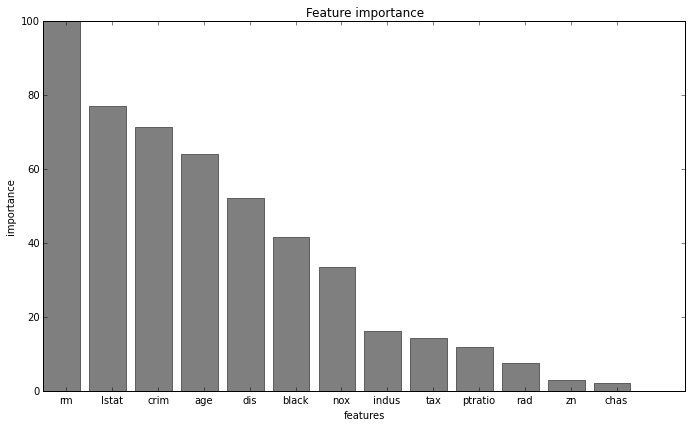

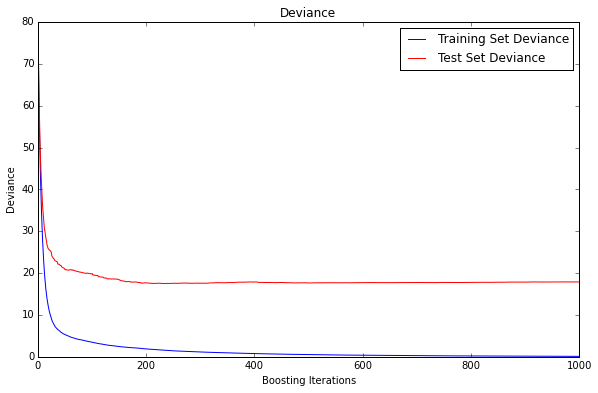

In [20]:
# plot variable importance
import numpy as np
import matplotlib.pyplot as plt

feature_importance = gbm.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(6 * 1.618, 6))
index = np.arange(len(feature_cols))
bar_width = 0.5
plt.bar(index, feature_importance[sorted_idx], color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index + bar_width, np.array(feature_cols)[sorted_idx])
plt.tight_layout()
plt.show()

# plot deviance for training set and test set
test_score = np.zeros(params['n_estimators'])

for j, y_pred in enumerate(gbm.staged_decision_function(X_test)):
    test_score[j] = gbm.loss_(y_test, y_pred)

plt.figure(figsize=(6 * 1.618, 6))
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, gbm.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## 4 Conclusion
The following table compares the performance of the three models. As expected, the R-squared value on test data is lower than that on training data for all models. 

The linear model after variable selection performs better on the test data than the model with all avariables. For example, the RMSE for the reduced model is 5.2006 compared with 5.2150 for the full model. So the simpler model (with 2 fewer variables) performs better than the more complex one. This illustrate the benefits of conducting variable selection.

GBM performs best among all models by all criteria. 

| Metric                    | Data          | Linear Reg - All Variables | Linear Reg - Selected Variables |    GBM |
|---------------------------|---------------|--------------:|-------------------:|-------:|
| R-squared                 | training data |        0.7645 |             0.7642 | 0.9988 |
| R-squared                 | test data     |        0.6734 |             0.6752 | 0.7852 |
| Mean Absolute   Error     | test data     |        3.6099 |             3.5951 | 2.5828 |
| Root Mean   Squared Error | test data     |        5.2150 |             5.2006 | 4.2295 |
| Relative   Absolute Error | test data     |        0.5561 |             0.5538 | 0.3979 |
| Relative   Squared Error  | test data     |        0.3266 |             0.3248 | 0.2148 |
